# Hyperparameter Sweep Analysis

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.path import Path

import numpy as np
import pandas as pd
import wandb

from src.config import conf

plt.rcParams["font.sans-serif"] = "Arial"

## Load Data

Load data from sweeps.

In [ ]:
sweep = wandb.Api().sweep(path=conf.sweep.wandb_path)
sweep_runs = {run.id: run for run in sweep.runs}

In [ ]:
metric_categories = {
    "metadata": {},
    "train": {},
    "val": {},
    "test": {},
    "edge_type_train": {},
    "edge_type_val": {},
    "edge_type_test": {},
    "gradients": {},
}

val_test_metric_names = {"accuracy", "ap", "auroc", "f1", "loss"}

for run_id, run in sweep_runs.items():
    run_summary = run.summary
    run_summary_dict = dict(run_summary)
    
    # Classify metric keys
    train_keys = {k for k in run_summary_dict if k.startswith("train/") and "edge_type" not in k}
    val_keys = {
        k
        for k in run_summary_dict
        if k.startswith("val/") and "edge_type" not in k and any(m in k for m in val_test_metric_names)
    }
    test_keys = {
        k
        for k in run_summary_dict
        if k.startswith("test/") and "edge_type" not in k and any(m in k for m in val_test_metric_names)
    }
    edge_type_keys = {k for k in run_summary_dict if "edge_type" in k}
    edge_type_train_keys = {k for k in edge_type_keys if "train" in k}
    edge_type_val_keys = {k for k in edge_type_keys if "val" in k}
    edge_type_test_keys = {k for k in edge_type_keys if "test" in k}
    gradient_keys = {k for k in run_summary_dict if "gradient" in k}
    
    # Determine metadata keys
    used_keys = train_keys | val_keys | test_keys | edge_type_keys | gradient_keys
    metadata_keys = set(run_summary_dict) - used_keys
    
    # Store metrics
    metric_categories["metadata"][run_id] = {k: run_summary_dict[k] for k in metadata_keys}
    metric_categories["train"][run_id] = {k: run_summary_dict[k] for k in train_keys}
    metric_categories["val"][run_id] = {k: run_summary_dict[k] for k in val_keys}
    metric_categories["test"][run_id] = {k: run_summary_dict[k] for k in test_keys}
    metric_categories["edge_type_train"][run_id] = {k: run_summary_dict[k] for k in edge_type_train_keys}
    metric_categories["edge_type_val"][run_id] = {k: run_summary_dict[k] for k in edge_type_val_keys}
    metric_categories["edge_type_test"][run_id] = {k: run_summary_dict[k] for k in edge_type_test_keys}
    metric_categories["gradients"][run_id] = {k: run_summary_dict[k] for k in gradient_keys}

dataframes = {key: pd.DataFrame(value).T for key, value in metric_categories.items()}

# Unpack data frames for individual use
metadata_df = dataframes["metadata"]
train_metrics_df = dataframes["train"]
val_metrics_df = dataframes["val"]
test_metrics_df = dataframes["test"]
edge_type_train_metrics_df = dataframes["edge_type_train"]
edge_type_val_metrics_df = dataframes["edge_type_val"]
edge_type_test_metrics_df = dataframes["edge_type_test"]

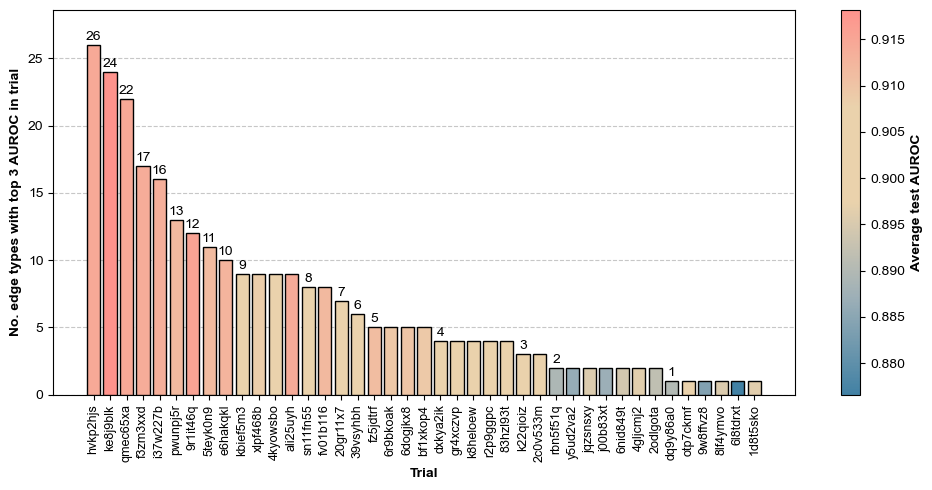

In [ ]:
# Set split
SPLIT = "test"
TOP_K = 3

# Define custom colormap
custom_hex_colors = ["#4281a4", "#9cafb7", "#ead2ac", "#ead2ac", "#fe938c"]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", custom_hex_colors, N=256)

# Subset to val AUROC
edge_type_val_auroc_df = edge_type_val_metrics_df.filter(regex="auroc$")
edge_type_test_auroc_df = edge_type_test_metrics_df.filter(regex="auroc$")

# For each column, find the row with the highest value
edge_type_val_auroc_df_max = edge_type_val_auroc_df.idxmax(axis=0)
edge_type_test_auroc_df_max = edge_type_test_auroc_df.idxmax(axis=0)

# For each column, find the rows with the top k () values
edge_type_val_auroc_df_topk = edge_type_val_auroc_df.apply(lambda x: x.nlargest(TOP_K).index)
edge_type_val_auroc_df_topk = edge_type_val_auroc_df_topk.stack().reset_index(name="trial")

edge_type_test_auroc_df_topk = edge_type_test_auroc_df.apply(lambda x: x.nlargest(TOP_K).index)
edge_type_test_auroc_df_topk = edge_type_test_auroc_df_topk.stack().reset_index(name="trial")

# Get trial counts for val AUROC
if SPLIT == "validation":
    if TOP_K == 1:
        trial_counts = edge_type_val_auroc_df_max.value_counts()
        trial_counts = pd.DataFrame(trial_counts).merge(val_metrics_df, left_index=True, right_index=True)
    else:
        trial_counts = edge_type_val_auroc_df_topk.value_counts("trial")
        trial_counts = pd.DataFrame(trial_counts).merge(val_metrics_df, left_index=True, right_index=True)
elif SPLIT == "test":
    if TOP_K == 1:
        trial_counts = edge_type_test_auroc_df_max.value_counts()
        trial_counts = pd.DataFrame(trial_counts).merge(test_metrics_df, left_index=True, right_index=True)
    else:
        trial_counts = edge_type_test_auroc_df_topk.value_counts("trial")
        trial_counts = pd.DataFrame(trial_counts).merge(test_metrics_df, left_index=True, right_index=True)
else:
    raise ValueError(f"Invalid SPLIT value: {SPLIT}")

# Normalize val/auroc values to colormap range
if SPLIT == "validation":
    norm = mcolors.Normalize(vmin=trial_counts["val/auroc"].min(), vmax=trial_counts["val/auroc"].max())
    colors = [custom_cmap(norm(val)) for val in trial_counts["val/auroc"]]
elif SPLIT == "test":
    norm = mcolors.Normalize(vmin=trial_counts["test/auroc"].min(), vmax=trial_counts["test/auroc"].max())
    colors = [custom_cmap(norm(val)) for val in trial_counts["test/auroc"]]
else:
    raise ValueError(f"Invalid SPLIT value: {SPLIT}")

# Create a bar plot of the number of max values per run
plt.figure(figsize=(10, 5))
plt.bar(trial_counts.index, trial_counts["count"], color=colors, edgecolor="black", zorder=3)

# Add colorbar
sm = cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label(f"Average {SPLIT} AUROC", fontweight="bold")

plt.xlabel("Trial", fontweight="bold")
if TOP_K == 1:
    plt.ylabel("No. edge types with maximum AUROC in trial", fontweight="bold")
else:
    plt.ylabel(f"No. edge types with top {TOP_K} AUROC in trial", fontweight="bold")
plt.xticks(rotation=90, fontsize=9)
plt.grid(axis="y", linestyle="--", alpha=0.7, zorder=0)
plt.tight_layout()

# Expand y-limit by 5%
plt.ylim(0, trial_counts["count"].max() * 1.1)

# Add text annotation above each bar
# Keep track of numbers and don't repeat
numbers = []
for i, row in trial_counts.iterrows():
    if row["count"] not in numbers:
        plt.text(i, row["count"] + 0.15, f"{row['count']:.0f}", ha="center", va="bottom")
        numbers.append(row["count"])

plt.savefig(conf.out_paths.output_dir / "top_edge_type_val_auroc.pdf")
plt.savefig(conf.out_paths.output_dir / "top_edge_type_val_auroc.svg")
plt.show()

In [ ]:
# Compute trial counts correlation with count vs. test/auroc
trial_counts["test/auroc"].corr(trial_counts["count"], method="spearman")

0.9056972410947766

In [ ]:
# Print models with top val AUROC
val_metrics_df.sort_values(by="val/auroc", ascending=False).head(10)

,val/accuracy,val/ap,val/f1,val/auroc,val/loss
ke8j9blk,0.828897,0.911506,0.828897,0.917901,0.429138
9r1it46q,0.826312,0.909238,0.826312,0.915541,0.429673
hvkp2hjs,0.822758,0.908723,0.822758,0.914807,0.435375
ali25uyh,0.822549,0.908585,0.822549,0.914453,0.446472
f3zm3xxd,0.823699,0.908191,0.823699,0.914363,0.443819
qmec65xa,0.824375,0.907621,0.824375,0.914338,0.434542
i37w227b,0.821936,0.907238,0.821936,0.913601,0.436950
e6hakqkl,0.821450,0.906476,0.821450,0.912688,0.457148
pwunpj5r,0.820881,0.905132,0.820881,0.911901,0.432931
fv01b116,0.820263,0.905644,0.820263,0.911615,0.451880


In [ ]:
# Print models with top test AUROC
test_metrics_df.sort_values(by="test/auroc", ascending=False).head(10)

,test/ap,test/auroc,test/f1,test/loss,test/accuracy
ke8j9blk,0.911756,0.918163,0.829259,0.429074,0.829259
9r1it46q,0.909138,0.915474,0.826489,0.432944,0.826489
qmec65xa,0.908081,0.914543,0.824560,0.435693,0.824560
hvkp2hjs,0.908451,0.914474,0.822323,0.435563,0.822323
ali25uyh,0.908320,0.914204,0.822187,0.451221,0.822187
f3zm3xxd,0.907747,0.913971,0.823459,0.446639,0.823459
i37w227b,0.907302,0.913596,0.821990,0.434821,0.821990
e6hakqkl,0.906592,0.912729,0.821504,0.454643,0.821504
pwunpj5r,0.905074,0.911877,0.820589,0.439489,0.820589
fv01b116,0.905948,0.911846,0.820643,0.450466,0.820643


In [ ]:
# Merge metrics tables
metrics_df = pd.merge(train_metrics_df, val_metrics_df, left_index=True, right_index=True)
metrics_df = pd.merge(metrics_df, test_metrics_df, left_index=True, right_index=True)
metrics_df = metrics_df.sort_values(by="test/auroc", ascending=False).head(10)

# Round to 4 decimal places
metrics_df = metrics_df.round(4)

# Order columns
metrics_df = metrics_df[
    [
        "train/auroc",
        "train/accuracy",
        "train/ap",
        "train/f1",
        "train/loss",
        "val/auroc",
        "val/accuracy",
        "val/ap",
        "val/f1",
        "val/loss",
        "test/auroc",
        "test/accuracy",
        "test/ap",
        "test/f1",
        "test/loss",
    ]
]

# Save to CSV
metrics_df.to_csv(conf.out_paths.output_dir / "metrics_df.csv")

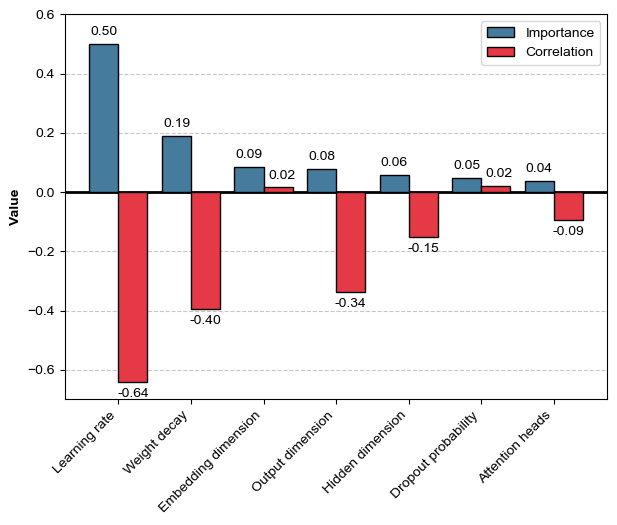

In [ ]:
# Manually get data from W&B
var_imp = {
    "Learning rate": [0.502, -0.642],
    "Weight decay": [0.190, -0.395],
    "Embedding dimension": [0.086, 0.016],
    "Output dimension": [0.078, -0.337],
    "Hidden dimension": [0.059, -0.152],
    "Dropout probability": [0.047, 0.020],
    "Attention heads": [0.038, -0.094],
}
var_imp_df = pd.DataFrame(var_imp, index=["Importance", "Correlation"]).T

# Plot figure
fig, ax = plt.subplots(figsize=(7, 5))
bar_width = 0.4
index = np.arange(len(var_imp_df))

# Plot bars side by side
ax.bar(
    index - bar_width / 2,
    var_imp_df["Importance"],
    bar_width,
    label="Importance",
    color="#457b9d",
    edgecolor="black",
    zorder=3,
)
ax.bar(
    index + bar_width / 2,
    var_imp_df["Correlation"],
    bar_width,
    label="Correlation",
    color="#e63946",
    edgecolor="black",
    zorder=3,
)

# Add horizontal line at y = 0
ax.axhline(y=0, color="black", linewidth=2, linestyle="-", zorder=2)

# Formatting
ax.set_xticks(index)
ax.set_xticklabels(var_imp_df.index, rotation=45, ha="right")
ax.set_ylabel("Value", fontweight="bold")
ax.legend()

# Add grid
ax.grid(axis="y", linestyle="--", alpha=0.7, zorder=0)

# Add text annotation above and below the bars
for i, row in var_imp_df.iterrows():
    i_index = var_imp_df.index.get_loc(i)
    ax.text(i_index - bar_width / 2, row["Importance"] + 0.02, f"{row['Importance']:.2f}", ha="center", va="bottom")
    if row["Correlation"] < 0:
        ax.text(i_index + bar_width / 2, row["Correlation"] - 0.02, f"{row['Correlation']:.2f}", ha="center", va="top")
    else:
        ax.text(
            i_index + bar_width / 2 + 0.05,
            row["Correlation"] + 0.02,
            f"{row['Correlation']:.2f}",
            ha="center",
            va="bottom",
        )

# Expand axis limits
ax.set_ylim(-0.7, 0.6)

# Save figure
plt.savefig(conf.out_paths.output_dir / "variable_importance.pdf", bbox_inches="tight")
plt.savefig(conf.out_paths.output_dir / "variable_importance.svg", bbox_inches="tight")

plt.show()

In [ ]:
# List out the hyperparameter keys
param_keys = ["dropout_prob", "hidden_dim", "lr", "num_feat", "num_heads", "output_dim", "wd"]

# Loop over runs in the sweep and build records for each
records = []
for run in sweep.runs:
    test_auroc = run.summary.get("test/auroc", float("nan"))
    run_params = {k: run.config.get(k, float("nan")) for k in param_keys}
    row_dict = {"run_id": run.id, "test/auroc": test_auroc}
    row_dict.update(run_params)
    records.append(row_dict)

# Table of hyperparameters and test AUROC across runs
hparams_df = pd.DataFrame(records)

# Drop rows with NA
na_rows = hparams_df[hparams_df.isna().any(axis=1)]
hparams_df = hparams_df.dropna().reset_index(drop=True)

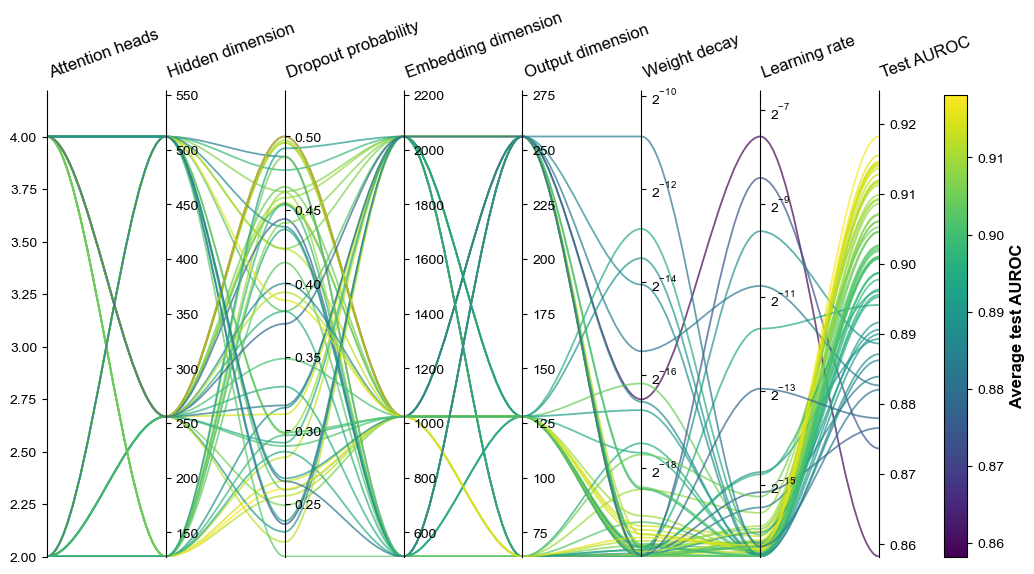

In [ ]:
# Rename columns in-place
hparams_df = hparams_df.rename(
    columns={
        "lr": "Learning rate",
        "wd": "Weight decay",
        "output_dim": "Output dimension",
        "num_feat": "Embedding dimension",
        "dropout_prob": "Dropout probability",
        "hidden_dim": "Hidden dimension",
        "num_heads": "Attention heads",
        # 'val/auroc':     'Validation AUROC'
        "test/auroc": "Test AUROC",
    }
)

# Select columns to plot
param_cols = [
    "Attention heads",
    "Hidden dimension",
    "Dropout probability",
    "Embedding dimension",
    "Output dimension",
    "Weight decay",
    "Learning rate",
    # 'Validation AUROC'
    "Test AUROC",
]

Y = hparams_df[param_cols].values
N, n_params = Y.shape

# Compute min/max of each column for the separate y-axes
ymins = Y.min(axis=0)
ymaxs = Y.max(axis=0)
dys = ymaxs - ymins

ymaxs += 0.1 * dys
dys = ymaxs - ymins

Z = np.zeros_like(Y)
Z[:, 0] = Y[:, 0]
for i in range(1, n_params):
    Z[:, i] = (Y[:, i] - ymins[i]) / (dys[i] + 1e-8) * dys[0] + ymins[0]

fig, host = plt.subplots(figsize=(12, 6))
axes = [host] + [host.twinx() for _ in range(n_params - 1)]

# Configure axes per parameter
for i, ax in enumerate(axes):
    ax.set_ylim(ymins[i], ymaxs[i])
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    if ax != host:
        ax.spines["left"].set_visible(False)
        ax.yaxis.set_ticks_position("right")
        ax.spines["right"].set_position(
            ("axes", i / (n_params - 1))
        )

    # Use a log scale for learning rate and weight decay
    if param_cols[i] == "Learning rate" or param_cols[i] == "Weight decay":
        ax.set_yscale("log", base=2)

host.set_xlim(0, n_params - 1)
host.set_xticks(range(n_params))
host.set_xticklabels(param_cols, fontsize=12, rotation=20, ha="left")
host.tick_params(axis="x", which="major", pad=7)
host.spines["right"].set_visible(False)
host.xaxis.tick_top()

# Color each run by test AUROC
cmap = plt.get_cmap("viridis")
norm = mcolors.Normalize(vmin=hparams_df["Test AUROC"].min(), vmax=hparams_df["Test AUROC"].max())

# Top run IDs
top_run_ids = list(hparams_df.sort_values(by="Test AUROC", ascending=False).head(3)["run_id"].values)
top_run_id_colors = ["#e76f51", "#f4a261", "#e9c46a", "#2a9d8f", "#264653"]

# Plot each run as a Bezier spline across all axes
for i in range(N):
    x_coords = np.linspace(0, n_params - 1, n_params * 3 - 2, endpoint=True)
    y_coords = np.repeat(Z[i, :], 3)[1:-1]

    verts = list(zip(x_coords, y_coords, strict=False))
    codes = [Path.MOVETO] + [Path.CURVE4] * (len(verts) - 1)
    path = Path(verts, codes)

    color = cmap(norm(hparams_df["Test AUROC"].iloc[i]))
    patch = patches.PathPatch(path, facecolor="none", lw=1.3, edgecolor=color, alpha=0.7)  # alpha_vals[i]
    host.add_patch(patch)

# Add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=host, fraction=0.035, pad=0.07)
cbar.set_label("Average test AUROC", fontsize=12, fontweight="bold")

# plt.tight_layout()
plt.savefig(conf.out_paths.output_dir / "parallel_coordinates.pdf", bbox_inches="tight")
plt.savefig(conf.out_paths.output_dir / "parallel_coordinates.svg", bbox_inches="tight")
plt.show()

## Generate Plots Per Run

Generate plots to show the performance of different runs.

In [ ]:
RUN_IDS = ["9r1it46q", "ke8j9blk", "hvkp2hjs", "pwunpj5r"]

In [ ]:
metric_names = ["auroc", "accuracy", "ap", "f1", "loss"]
metric_labels = {
    "auroc": "AUROC",
    "accuracy": "accuracy",
    "ap": "average precision",
    "f1": "$F_1$ score",
    "loss": "loss",
}


def plot_metrics(metrics_df, steps, metric_name, metric_split=None, run_id=None):
    plt.figure(figsize=(4.5, 4.5))

    # If first step is not 0, duplicate first step
    if metrics_df["_step"].values[0] != 0:
        metrics_df = pd.concat([
            pd.DataFrame({
                "_step": [0],
                "epoch": steps["epoch"].values[0],
                metric_name: metrics_df[metric_name].values[0],
            }),
            metrics_df,
        ])

    # If accuracy, multiply by 100
    if metric_name == "accuracy":
        metrics_df[metric_name] = metrics_df[metric_name] * 100

    # If validation, plot black
    if metric_split == "Validation":
        plt.plot(
            metrics_df["_step"].values, metrics_df[metric_name].values, color="black", zorder=3, linewidth=2, alpha=1
        )

    # If train, plot black with high alpha, then plot smoothed line with low alpha
    elif metric_split == "Train":
        plt.plot(
            metrics_df["_step"].values,
            metrics_df[metric_name].values,
            color="black",
            zorder=3,
            linewidth=1.5,
            alpha=0.2,
        )

        # Generate smoothed line
        smoothed_df = metrics_df.copy()
        smoothed_df[metric_name] = smoothed_df[metric_name].rolling(window=25, min_periods=1).mean()

        plt.plot(
            smoothed_df["_step"].values, smoothed_df[metric_name].values, color="red", zorder=5, linewidth=2, alpha=1
        )

    plt.xlabel("Step", fontweight="bold")
    extreme_value = metrics_df[metric_name].min() if metric_name == "loss" else metrics_df[metric_name].max()
    extreme_operator = "min" if metric_name == "loss" else "max"
    if metric_split is not None:
        plt.ylabel(
            f"{metric_split} {metric_labels[metric_name]} ({extreme_operator} = {extreme_value:.4f})", fontweight="bold"
        )
    else:
        plt.ylabel(metric_labels[metric_name], fontweight="bold")
    plt.grid(True, linestyle="--", alpha=0.7, zorder=0)
    plt.xlim(min(steps["_step"].values), max(steps["_step"].values))
    ymax = max(metrics_df[metric_name].values)

    # Add shaded background for epochs
    epochs = steps["epoch"].unique()
    epoch_colors = ["#f1faee", "#a8dadc", "#457b9d"]
    for _i, epoch in enumerate(epochs):
        step_start = steps[steps["epoch"] == epoch]["_step"].min()
        step_end = steps[steps["epoch"] == epoch]["_step"].max()

        # Alternate shading
        color = epoch_colors[epoch]
        plt.axvspan(step_start, step_end, color=color, alpha=0.3, zorder=0)
        if epoch != 2:
            plt.axvline(x=step_end, color="gray", linestyle="--", alpha=0.7, zorder=1)

        # Add text annotation for epoch
        plt.text(
            (step_start + step_end) / 2,
            ymax,
            f"Epoch {epoch + 1}",
            fontsize=10,
            fontweight="bold",
            ha="center",
            color="black",
        )

    run_dir = conf.out_paths.output_dir / run_id
    run_dir.mkdir(parents=True, exist_ok=True)

    filename = f"{run_id}_{metric_split.lower()}_{metric_name}.pdf" if metric_split else f"{run_id}_{metric_name}.pdf"
    plt.savefig(run_dir / filename, bbox_inches="tight")
    plt.savefig(run_dir / filename.replace(".pdf", ".svg"), bbox_inches="tight")

    plt.close()

In [ ]:
for run_id in RUN_IDS:
    run = wandb.Api().run(f"{conf.sweep.wandb_runs_path}/{run_id}")

    # Note that the history method samples the data up to 500 observations
    steps = run.history(keys=["_step", "epoch"])
    train_metrics = run.history(keys=["train/" + metric for metric in metric_names] + ["epoch"])
    val_metrics = run.history(keys=["val/" + metric for metric in metric_names] + ["epoch"])
    test_metrics = run.history(keys=["test/" + metric for metric in metric_names] + ["epoch"])

    train_metrics.rename(columns={"train/" + metric: metric for metric in metric_names}, inplace=True)
    val_metrics.rename(columns={"val/" + metric: metric for metric in metric_names}, inplace=True)
    test_metrics.rename(columns={"test/" + metric: metric for metric in metric_names}, inplace=True)

    for metric_name in metric_names:
        plot_metrics(train_metrics, steps, metric_name, metric_split="Train", run_id=run_id)
        plot_metrics(val_metrics, steps, metric_name, metric_split="Validation", run_id=run_id)